    0. Installing Packages


In [ ]:
!pip install graphviz
!pip install -U -q PyDrive

In [4]:
!pip install sklearn



In [7]:
!jupyter kernelspec list
import sys

sys.path
sys.executable


Available kernels:
  python3    C:\Users\georg\AppData\Roaming\jupyter\kernels\python3


'C:\\Users\\georg\\Anaconda3\\envs\\tensorflow_env\\python.exe'

In [7]:
!python --version

Python 3.7.1


1. Loading Data and Packages


In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import Lasso
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, PolynomialFeatures
import pickle
from sklearn.externals import joblib
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


# pentru google collab
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

### *! For the input files ( in case you use google collab ) *

In [0]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

### Load train and Test set

In [2]:
# downloaded = drive.CreateFile({'id': "1Nlg6gxJuwe6Rk5nDXbNqHVuTJbtpJict"}) #  fisier_id 
# downloaded.GetContentFile('train.csv') 
train = pd.read_csv("train.csv")

# downloaded = drive.CreateFile({'id': "1TeMDF6FBIC8D1H6L7eCfoj3dUH39zGRo"}) #  fisier_id 
# downloaded.GetContentFile('test.csv')
test = pd.read_csv("test.csv")

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

train = train[["OverallQual", 
               "MSSubClass", "FullBath", 
               "TotRmsAbvGrd", "YearBuilt", 
               "GrLivArea", "KitchenQual", 
               "GarageCars", "SalePrice"]]

test = test[["OverallQual", 
           "MSSubClass", "FullBath", 
           "TotRmsAbvGrd", "YearBuilt", 
           "GrLivArea", "KitchenQual", 
           "GarageCars"]]



In [4]:
# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 9) 
The test data size after dropping Id feature is : (1459, 8) 


In [5]:
train.head()

OverallQual  MSSubClass  FullBath  TotRmsAbvGrd  YearBuilt  GrLivArea  \
0            7          60         2             8       2003       1710   
1            6          20         2             6       1976       1262   
2            7          60         2             6       2001       1786   
3            7          70         1             7       1915       1717   
4            8          60         2             9       2000       2198   

  KitchenQual  GarageCars  SalePrice  
0          Gd           2     208500  
1          TA           2     181500  
2          Gd           2     223500  
3          Gd           3     140000  
4          Gd           3     250000

In [6]:
test.head()

OverallQual  MSSubClass  FullBath  TotRmsAbvGrd  YearBuilt  GrLivArea  \
0            5          20         1             5       1961        896   
1            6          20         1             6       1958       1329   
2            5          60         2             6       1997       1629   
3            6          60         2             7       1998       1604   
4            8         120         2             5       1992       1280   

  KitchenQual  GarageCars  
0          TA         1.0  
1          Gd         1.0  
2          TA         2.0  
3          Gd         2.0  
4          Gd         2.0

### 2. Analyzing the Test Variable (Sale Price)
Let's check out the most interesting feature in this study: Sale Price. Important Note: This data is from Ames, Iowa. The location is extremely correlated with Sale Price. (I had to take a double-take at a point, since I consider myself a house-browsing enthusiast)

In [7]:
# Getting Description
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



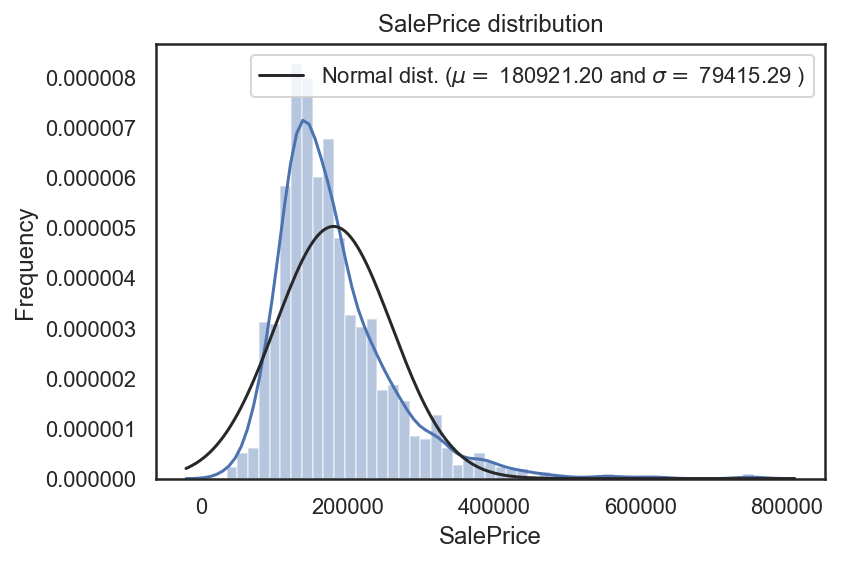

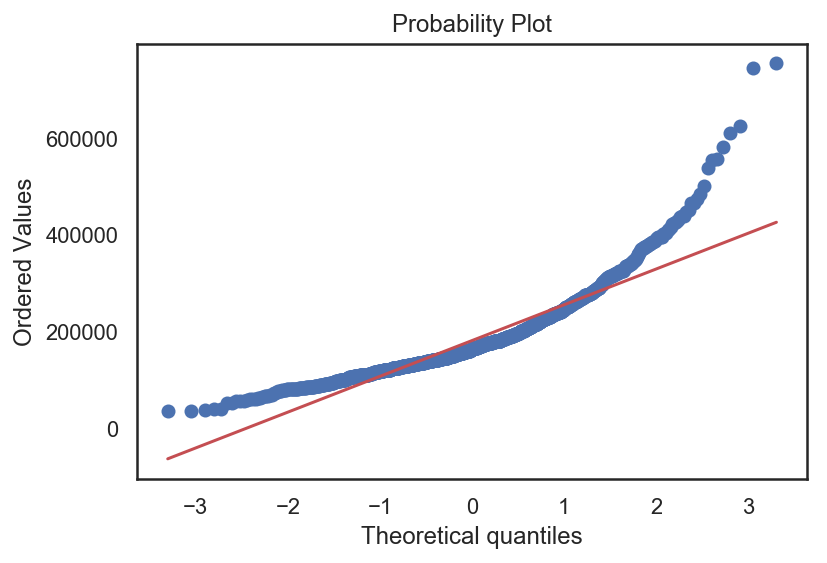

Skewness: 1.882876
Kurtosis: 6.536282


In [8]:
# Plot Histogram
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

### 3. Multivariable Analysis
Let's check out all the variables! There are two types of features in housing data, categorical and numerical.

Categorical data is just like it sounds. It is in categories. It isn't necessarily linear, but it follows some kind of pattern. For example, take a feature of "Downtown". The response is either "Near", "Far", "Yes", and "No". Back then, living in downtown usually meant that you couldn't afford to live in uptown. Thus, it could be implied that downtown establishments cost less to live in. However, today, that is not the case. (Thank you, hipsters!) So we can't really establish any particular order of response to be "better" or "worse" than the other.

Numerical data is data in number form. (Who could have thought!) These features are in a linear relationship with each other. For example, a 2,000 square foot place is 2 times "bigger" than a 1,000 square foot place. Plain and simple. Simple and clean.

In [9]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['KitchenQual'], dtype='object')

In [10]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['OverallQual', 'MSSubClass', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'GrLivArea', 'GarageCars', 'SalePrice'],
      dtype='object')

In [11]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  1 categorical + 8 numerical = 9 features


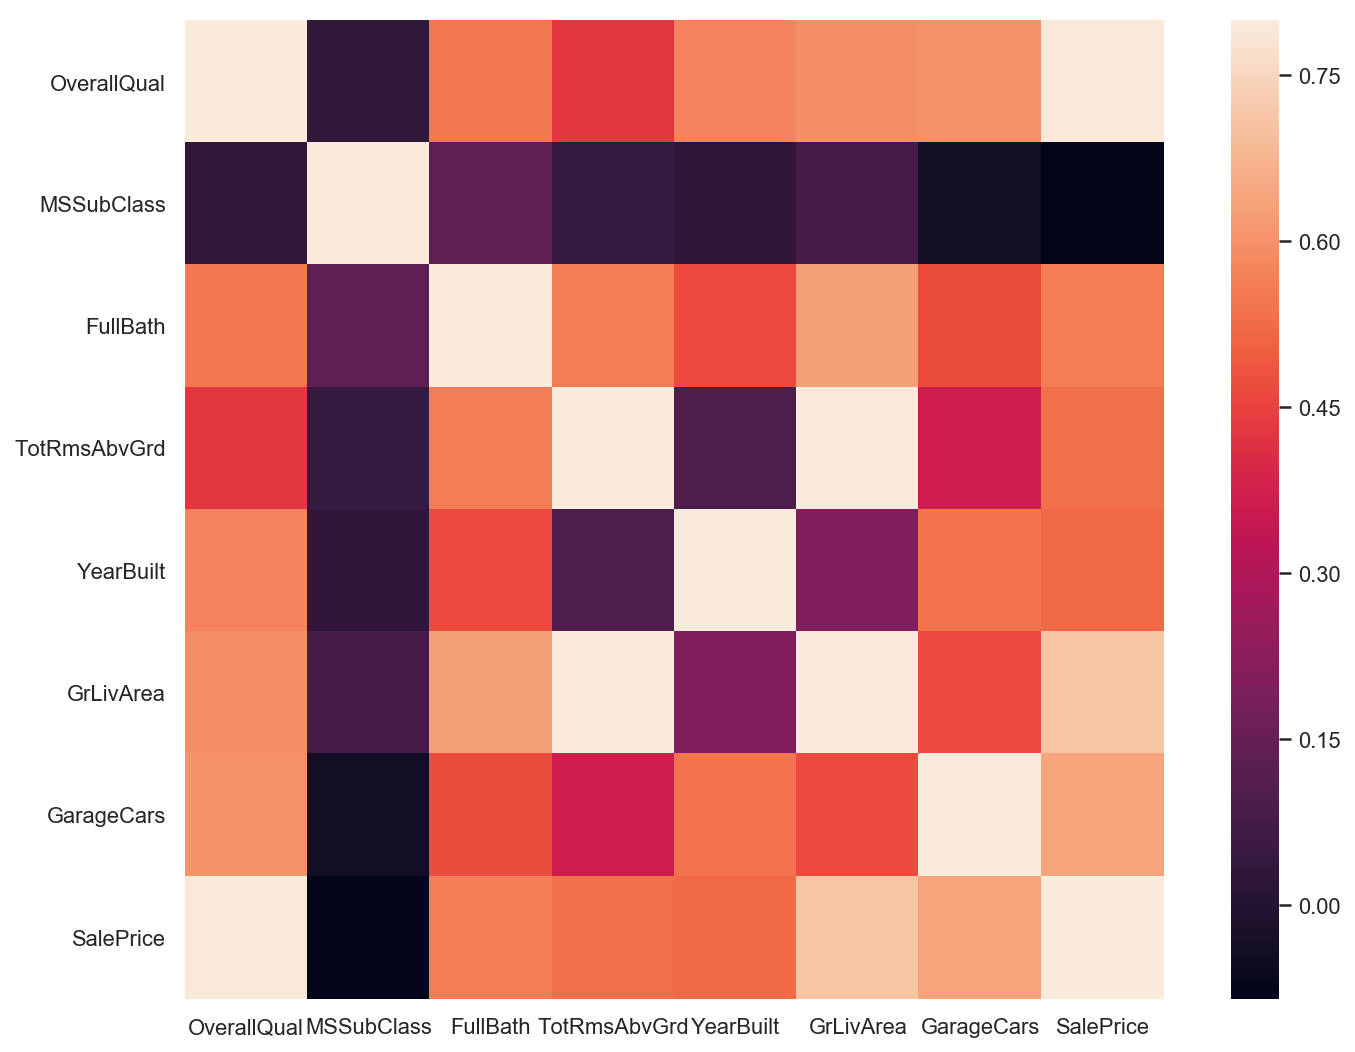

In [12]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

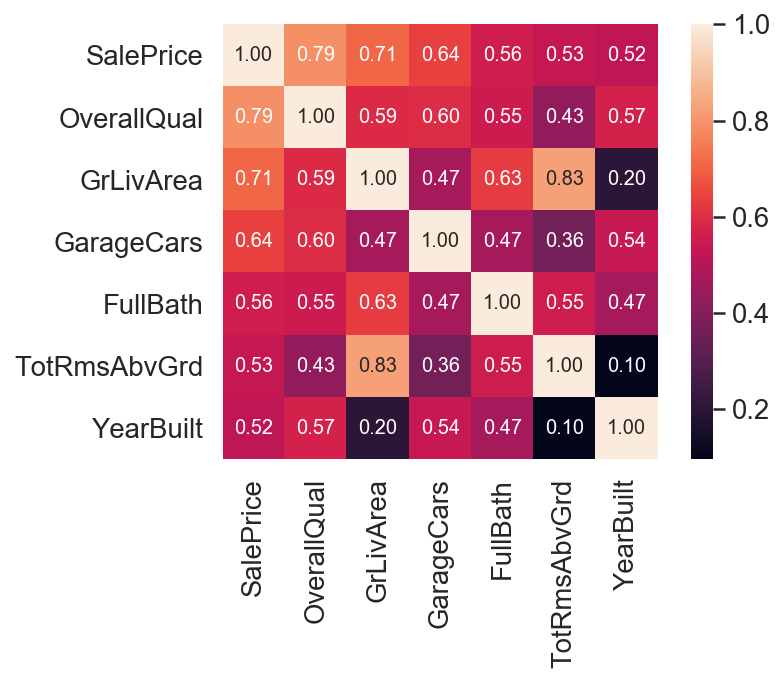

In [13]:
# Top 10 Heatmap
k = 7 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [14]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr


Most Correlated Features
0                SalePrice
1              OverallQual
2                GrLivArea
3               GarageCars
4                 FullBath
5             TotRmsAbvGrd
6                YearBuilt

Well, the most correlated feature to Sale Price is... Sale Price?!? Of course. For the other 6, they are as listed. Here is a short description of each. (Thank you, data_description.txt!)

> OverallQual: Rates the overall material and finish of the house (1 = Very Poor, 10 = Very Excellent)
> GrLivArea: Above grade (ground) living area square feet
> GarageCars: Size of garage in car capacity
> FullBath: Full bathrooms above grade
> TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
> YearBuilt: Original construction date


Let's take a look at how each relates to Sale Price and do some pre-cleaning on each feature if necessary.











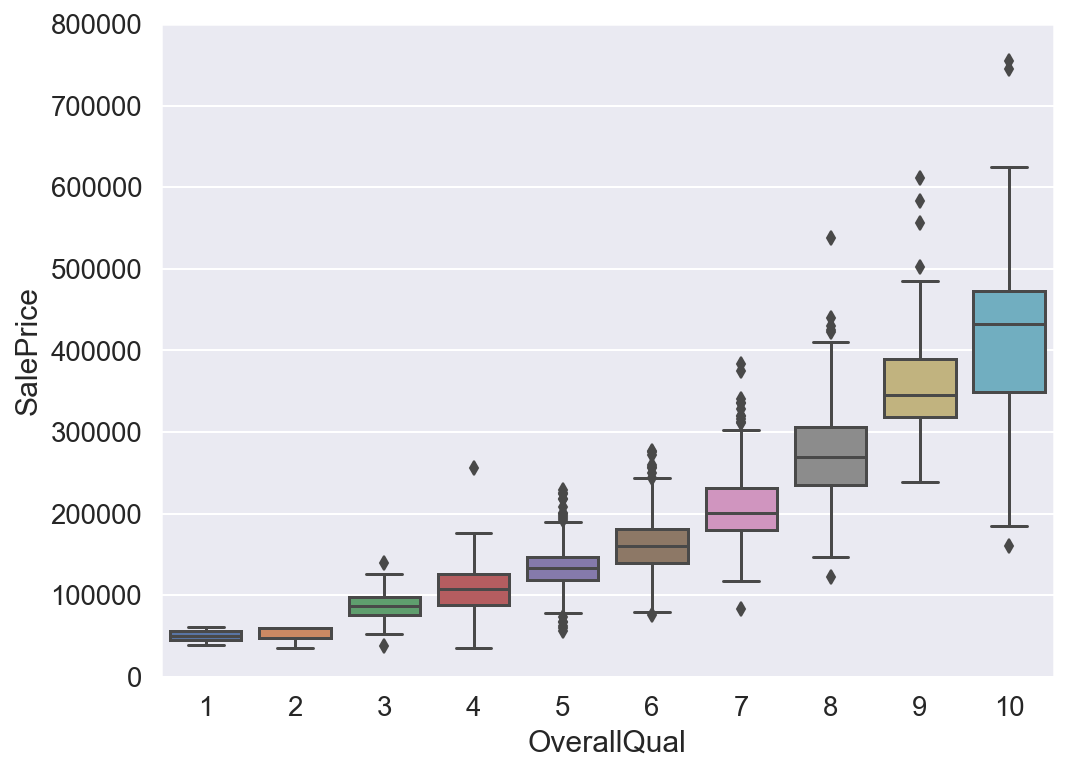

In [15]:
# Overall Quality vs Sale Price
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

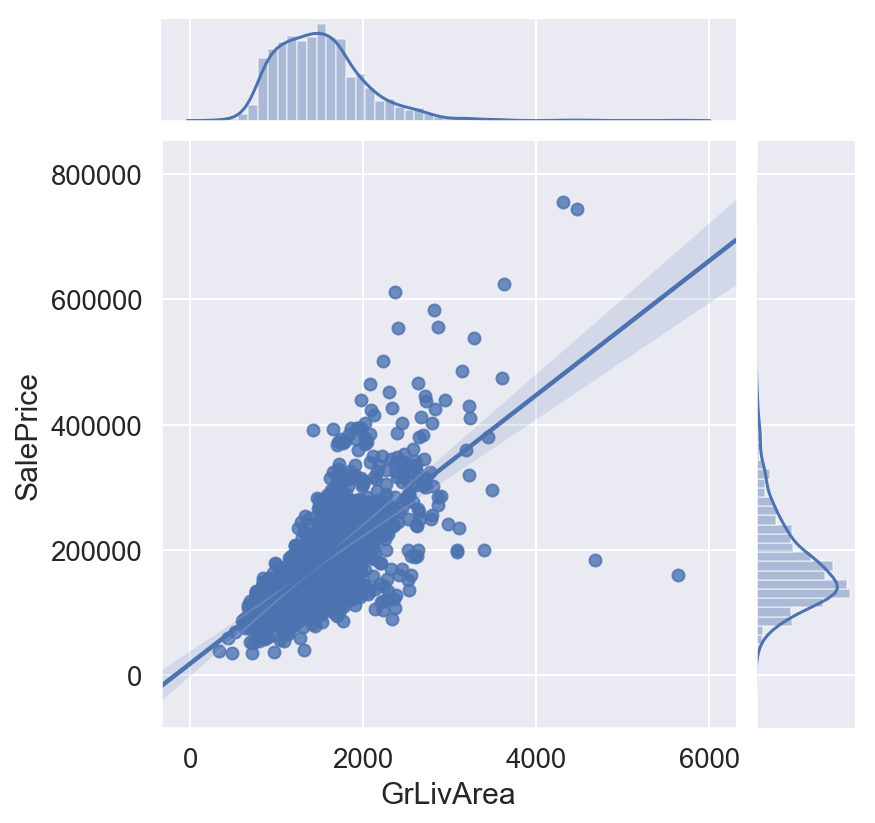

In [16]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

It makes sense that people would pay for the more living area. What doesn't make sense is the two datapoints in the bottom-right of the plot.

We need to take care of this! What we will do is remove these outliers manually.

In [17]:
# Removing outliers manually (Two points in the bottom right)
train = train.drop(train[(train['GrLivArea']>4000) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

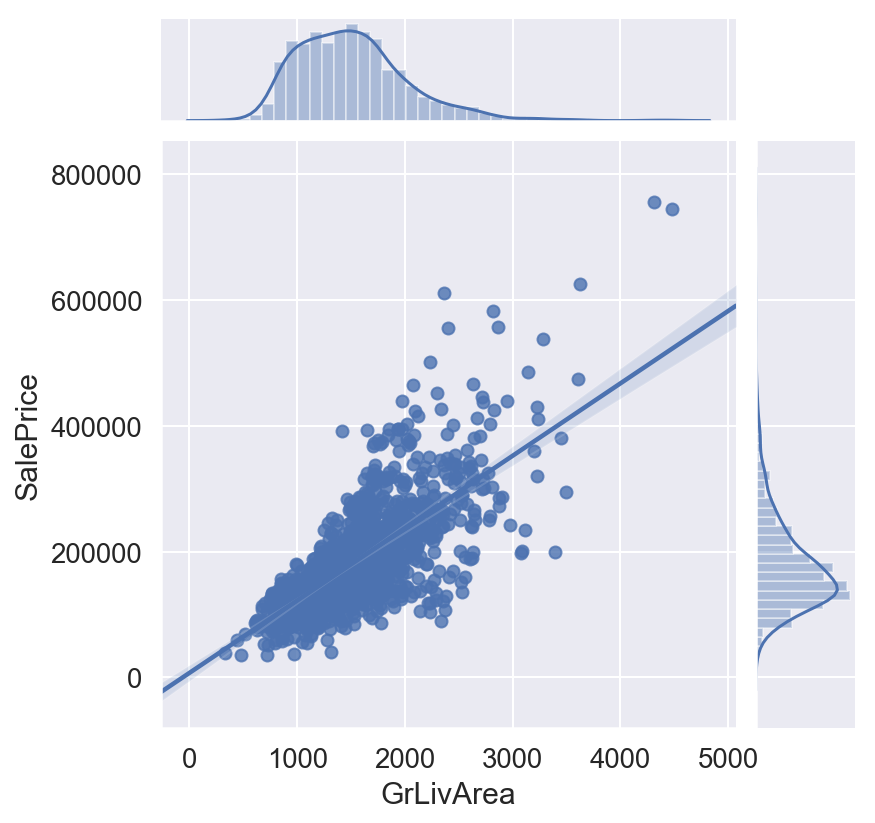

In [18]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

Nice! We got a 0.02 point increase in the Pearson-R Score.

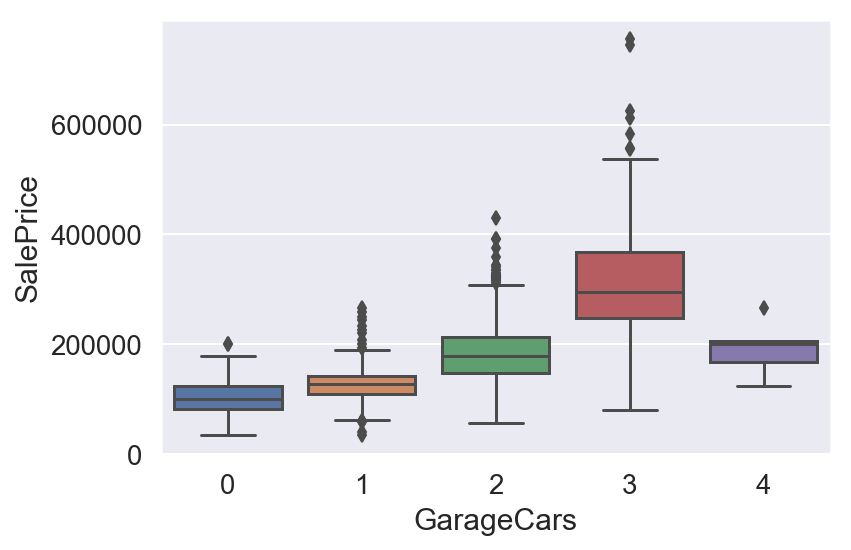

In [19]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

4-car garages result in less Sale Price? That doesn't make much sense. Let's remove those outliers.

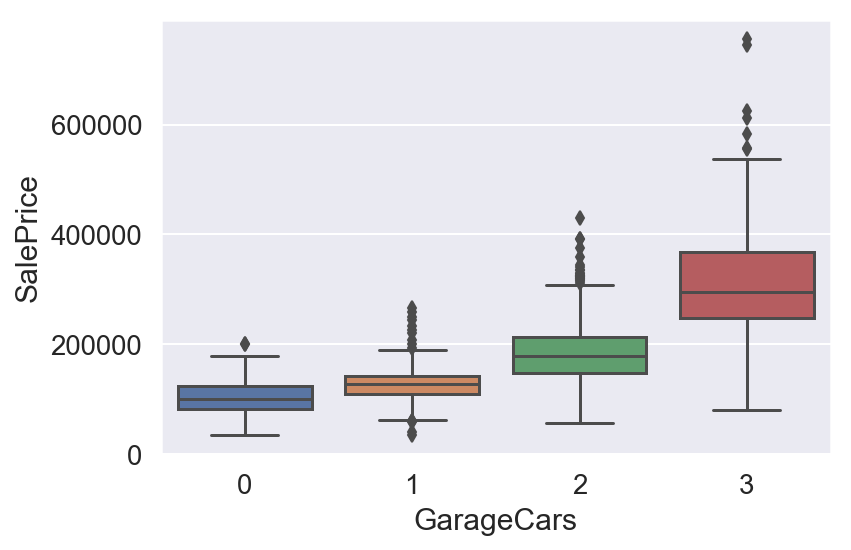

In [20]:
# Removing outliers manually (More than 4-cars, less than $300k)
train = train.drop(train[(train['GarageCars']>3) 
                         & (train['SalePrice']<300000)].index).reset_index(drop=True)

# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

That looks much better. Note: removal of data is totally discretionary and may or may not help in modeling. Use at your own preference.



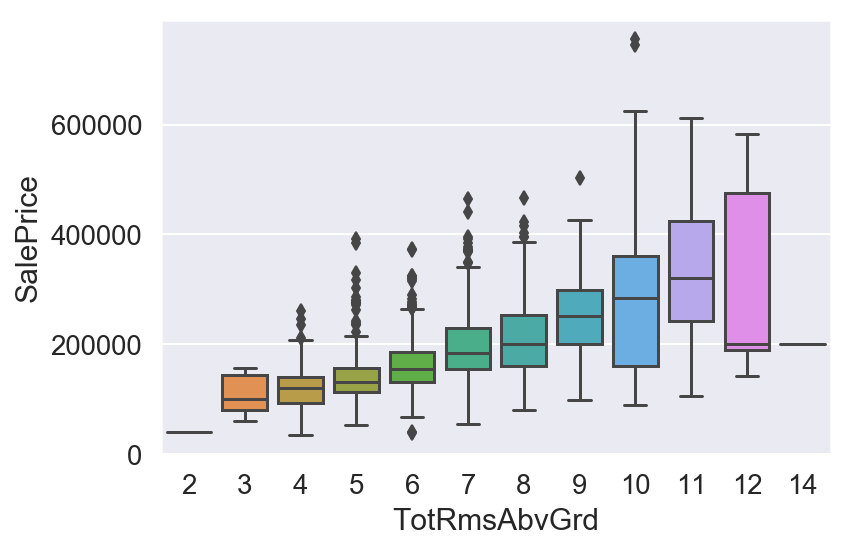

In [21]:
# Total Rooms vs Sale Price
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])

It seems like houses with more than 11 rooms come with a $100k off coupon. It looks like an outlier but I'll let it slide.

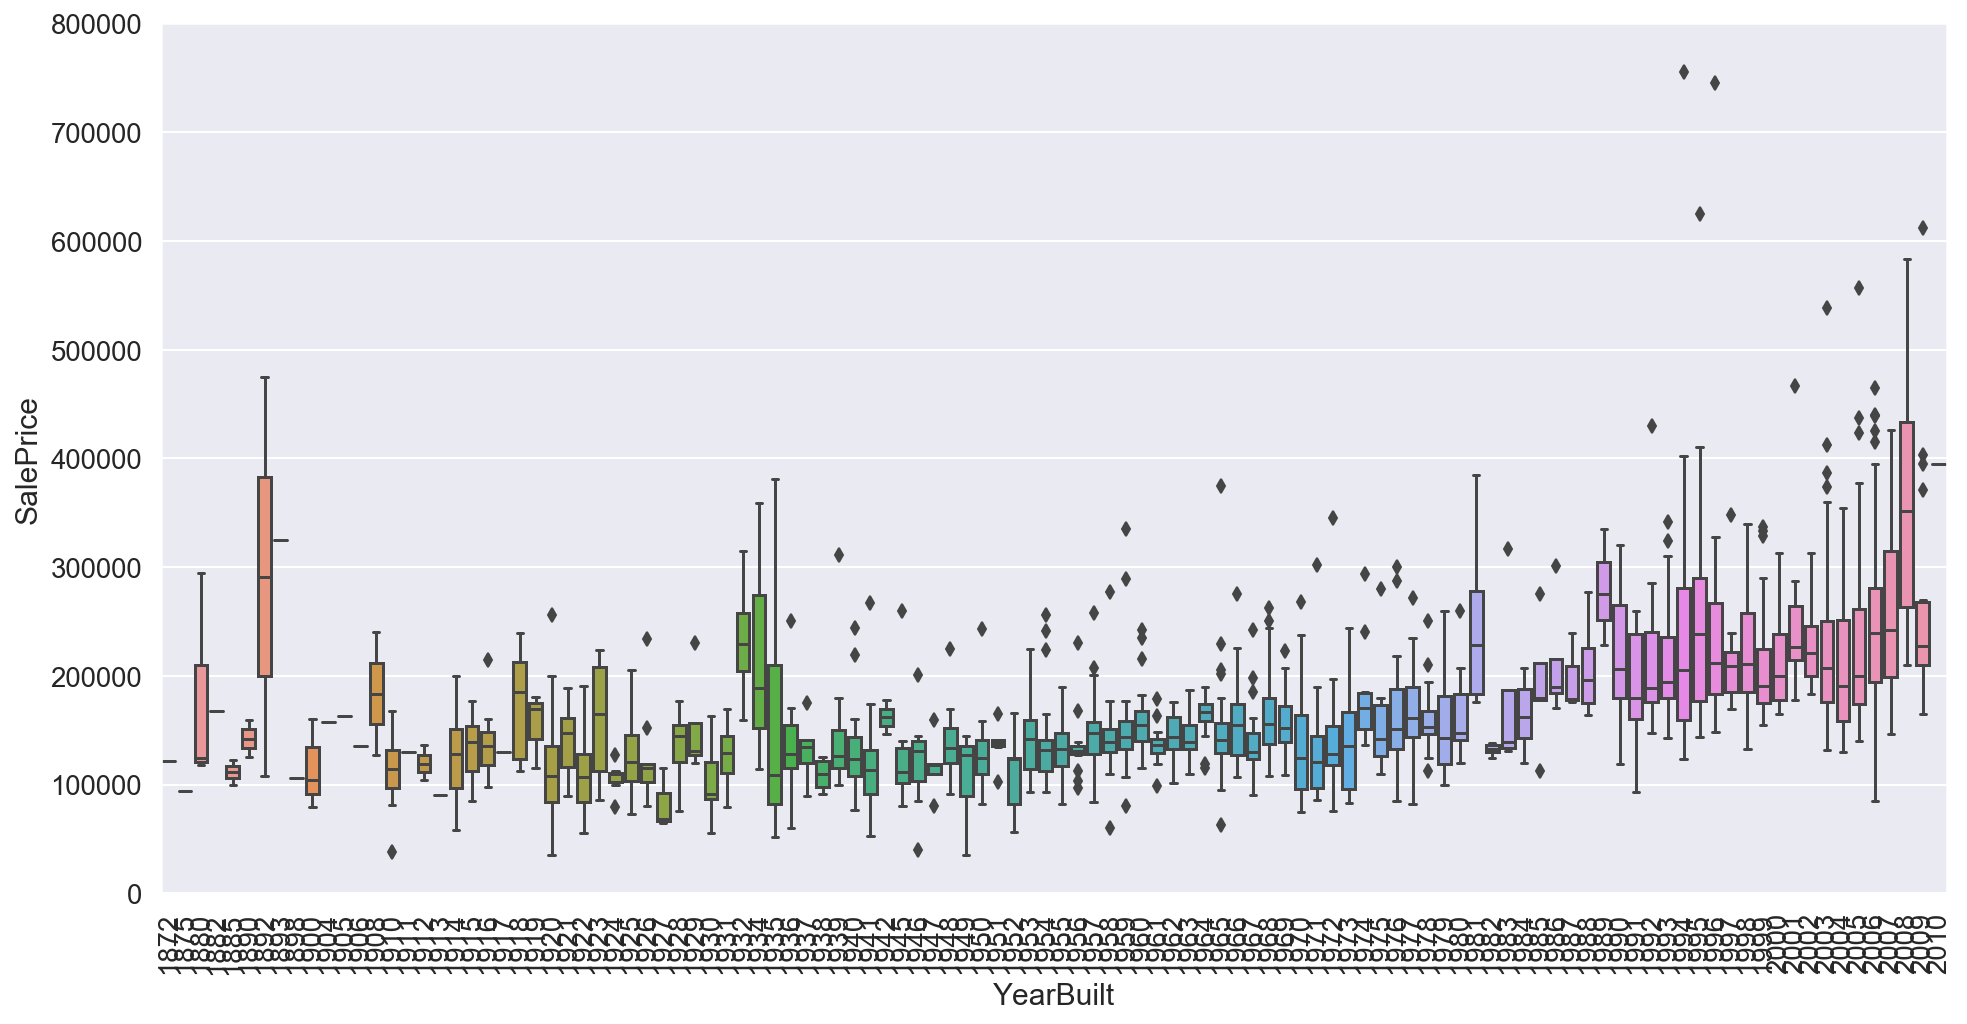

In [22]:
# Total Rooms vs Sale Price
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Although it seems like house prices decrease with age, we can't be entirely sure. Is it because of inflation or stock market crashes? Let's leave the years alone.

### 4. Impute Missing Data and Clean Data
Important questions when thinking about missing data:

How prevalent is the missing data?
Is missing data random or does it have a pattern?
The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hiding an inconvenient truth.

Let's combine both training and test data into one dataset to impute missing values and do some cleaning.

In [23]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (1453, 9)
Test data size is : (1459, 8)
Combined dataset size is : (2912, 8)


In [24]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

Missing Ratio
KitchenQual       0.034341
GarageCars        0.034341

Text(0.5, 1.0, 'Percent missing data by feature')

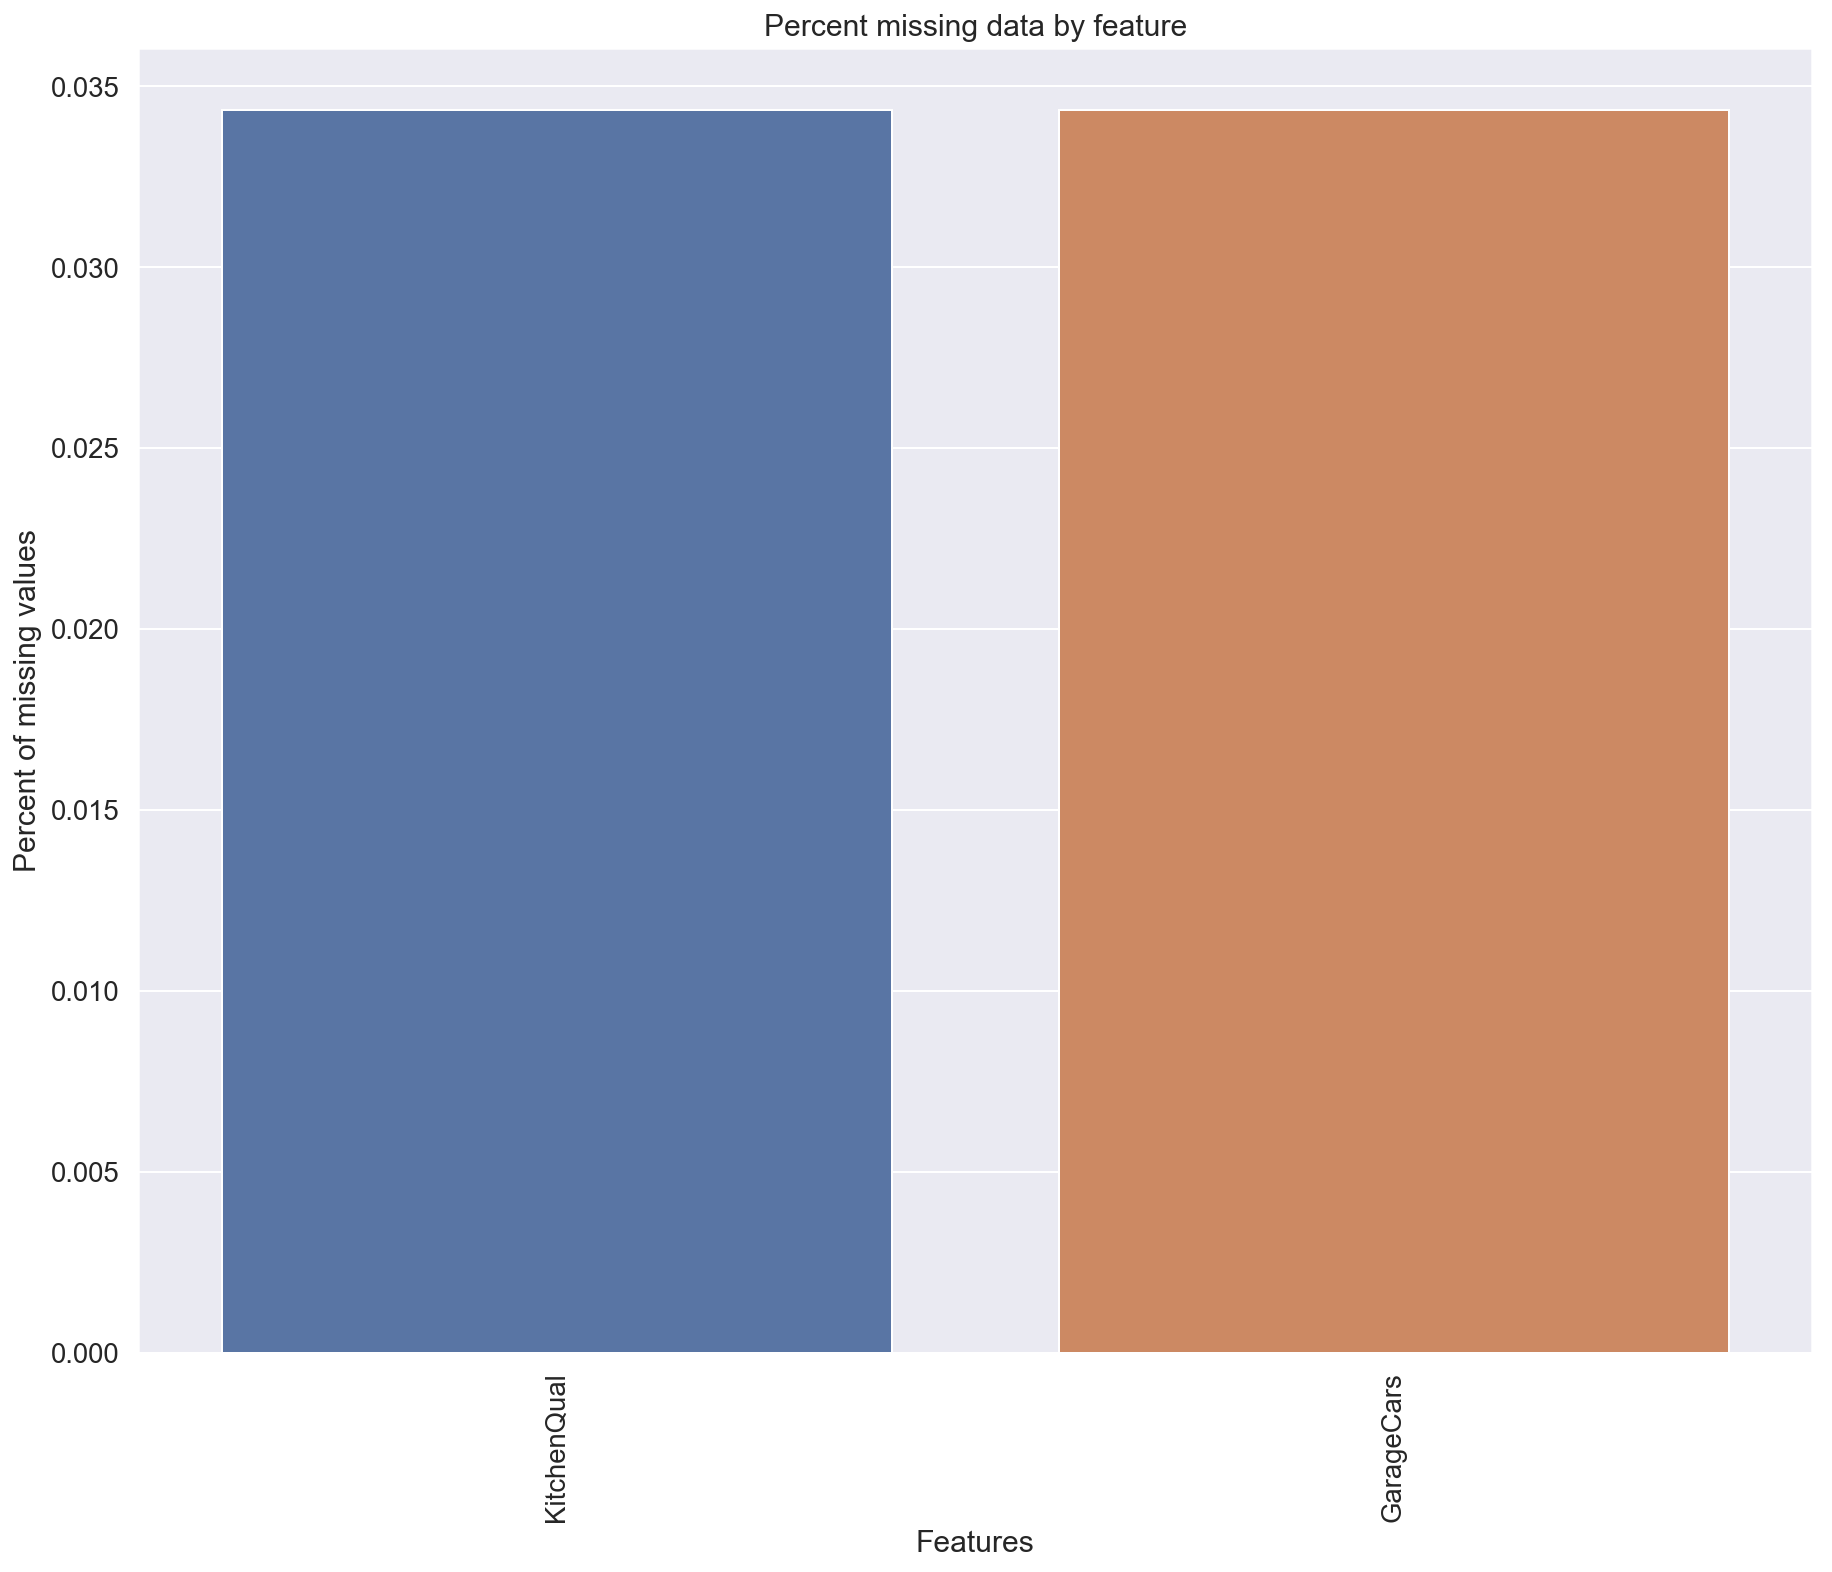

In [25]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

### Imputing Missing Values

*   KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.


*   GarageCars : Replacing missing data with 0.

In [26]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['GarageCars'] = all_data['GarageCars'].fillna(0)

In [27]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

### 5. Feature Transformation/Engineering
Let's take a look at some features that may be misinterpreted to represent something it's not.

MSSubClass: Identifies the type of dwelling involved in the sale.

*   20 1-STORY 1946 & NEWER ALL STYLES
*   30 1-STORY 1945 & OLDER
*   40 1-STORY W/FINISHED ATTIC ALL AGES
*   45 1-1/2 STORY - UNFINISHED ALL AGES
*   50 1-1/2 STORY FINISHED ALL AGES
*   60 2-STORY 1946 & NEWER
*   70 2-STORY 1945 & OLDER
*   75 2-1/2 STORY ALL AGES
*   80 SPLIT OR MULTI-LEVEL
*   85 SPLIT FOYER
*   90 DUPLEX - ALL STYLES AND AGES
*   120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
*   150 1-1/2 STORY PUD - ALL AGES
*   160 2-STORY PUD - 1946 & NEWER
*   180 PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
*   190 2 FAMILY CONVERSION - ALL STYLES AND AGES

In [28]:
all_data['MSSubClass'].describe()

count    2912.000000
mean       57.075893
std        42.482345
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

So, the average is a 57 type. What does that mean? Is a 90 type 3 times better than a 30 type? This feature was interpreted as numerical when it is actually categorical. The types listed here are codes, not values. Thus, we need to feature transformation with this and many other features.


In [29]:
#MSSubClass =The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

In our previous example, we could tell that our categories don't follow a particular order. What about categories that do? Let's take a look at "Kitchen Quality".

In [30]:
all_data['KitchenQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

Here, data_description.txt comes to the rescue again!

Kitchen Quality:

*   Ex: Excellent
*   Gd: Good
*   TA: Typical/Average
*   Fa: Fair
*   Po: Poor

Is a score of "Gd" better than "TA" but worse than "Ex"? I think so, let's encode these labels to give meaning to their specific orders.

In [31]:
from sklearn.preprocessing import LabelEncoder
cols = ('KitchenQual', 'MSSubClass')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))
print(all_data)

Shape all_data: (2912, 8)
      FullBath  GarageCars  GrLivArea  KitchenQual  MSSubClass  OverallQual  \
0            2         2.0       1710            2          10            7   
1            2         2.0       1262            3           5            6   
2            2         2.0       1786            2          10            7   
3            1         3.0       1717            2          11            7   
4            2         3.0       2198            2          10            8   
5            1         2.0       1362            3           9            5   
6            2         2.0       1694            2           5            8   
7            2         2.0       2090            3          10            7   
8            2         2.0       1774            3           9            7   
9            1         1.0       1077            3           4            5   
10           1         1.0       1040            3           5            5   
11           3         3.0

In [34]:
all_data = pd.get_dummies(all_data)

train = all_data[:ntrain]
test = all_data[ntrain:]

In [37]:
X = train
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
y_test

array([147000,  82000, 144000,  91000, 176432,  62383, 155000, 183200,
       124000, 117000, 255500, 122000, 120000, 386250, 144500, 172000,
       193500, 197900, 169000, 120000, 244000, 148000, 153000, 159000,
       124500, 138887,  82000, 139600, 132500, 168500, 124900, 145000,
       179500,  86000, 114504, 145000, 132500, 128000, 149900, 162000,
       202500, 151000, 270000, 230000, 147000, 167500, 167000, 189000,
       305900, 110000, 100000, 145250, 132000, 217000, 175500, 116000,
       139000, 106500, 167900,  89471, 121600, 129000, 106500, 193500,
       180000, 191000, 182000, 132000, 181000, 109900, 134900,  98300,
       144000, 135000, 153500, 261500, 143000, 172500, 119200, 136500,
       140000, 186700, 220000, 226000, 178000, 230000, 161000, 250000,
       219500, 149500, 170000, 206900, 237000, 169000, 150500,  86000,
        82500, 360000, 157900, 281213, 239799, 275000, 145000,  76500,
       340000, 466500, 128000,  98000, 210000, 179200, 233230, 140000,
      

In [39]:
features = PolynomialFeatures(degree=X.shape[1])
X_transformed = features.fit_transform(X)
X_train_transformed = features.fit_transform(X_train)
X_test_transformed = features.fit_transform(X_test)

Best Model = Lasso(alpha=0.0005) performance = 0.79468


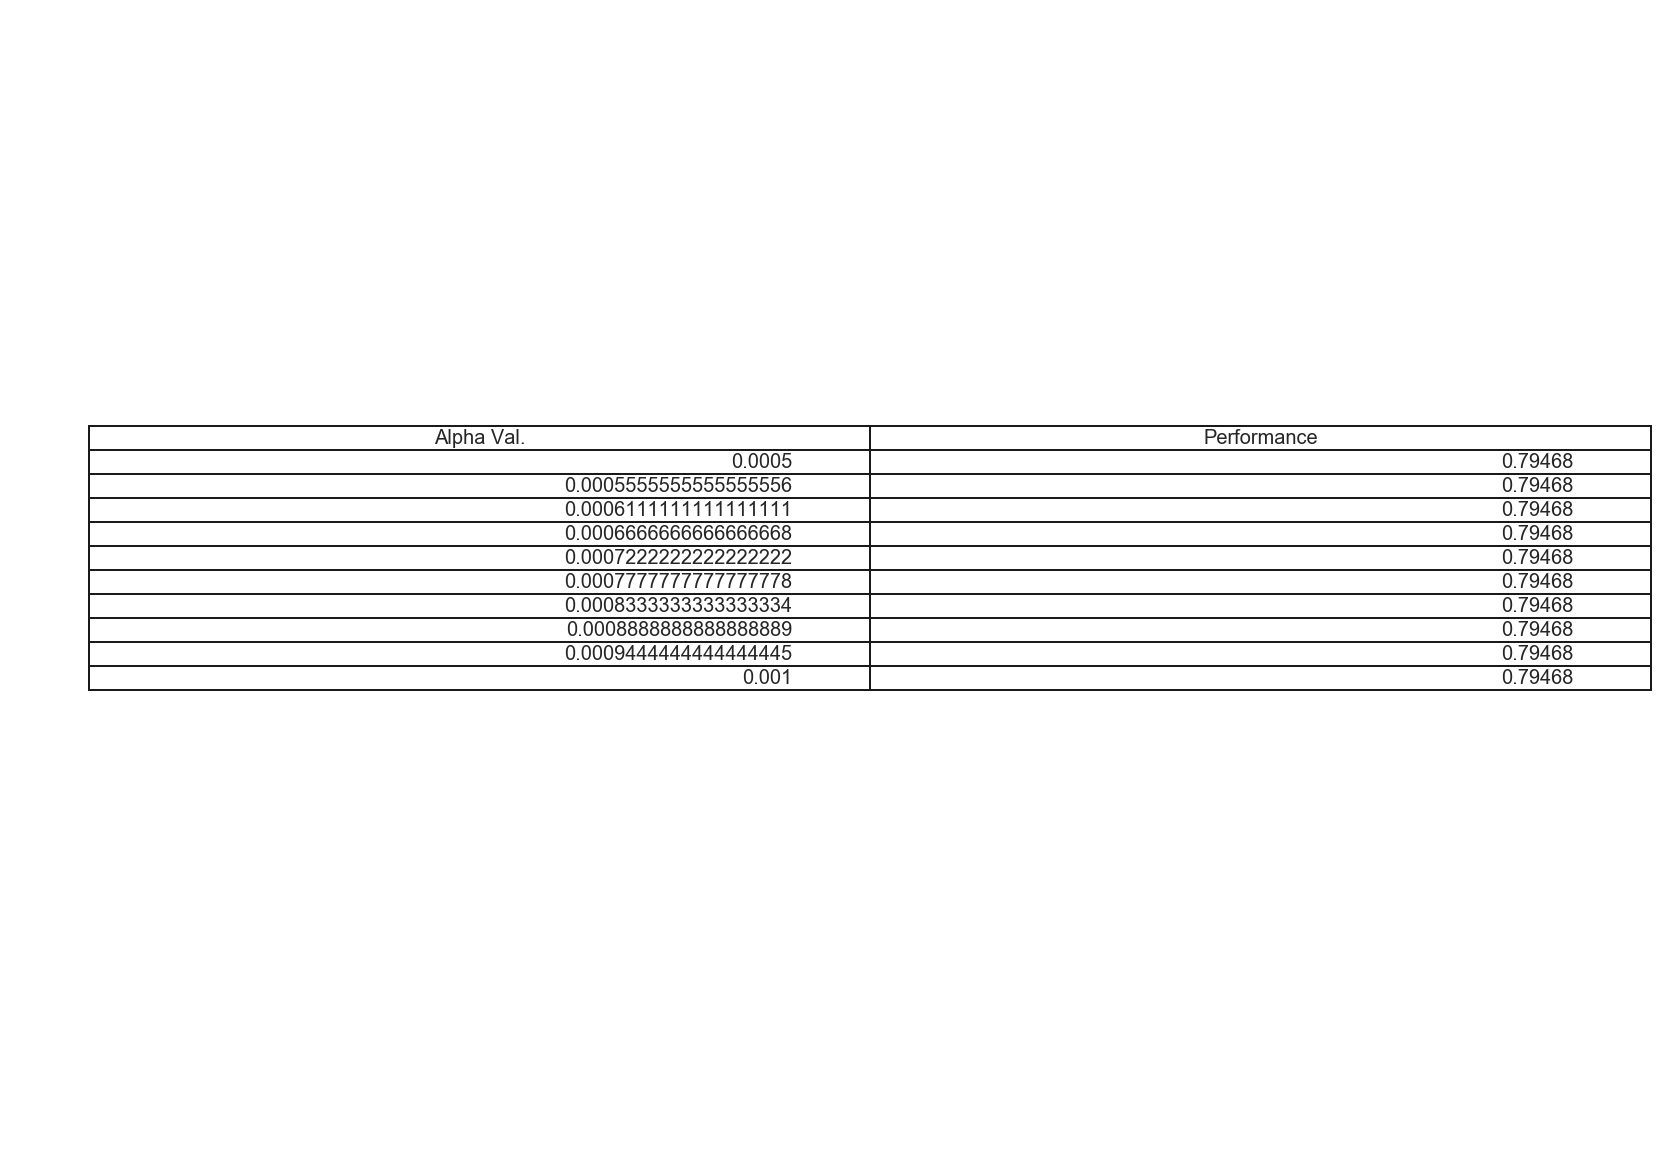

In [50]:
# lasso

alphaV = np.linspace(0.0005, 0.001, 10)

collabel = ("Alpha Val.", "Performance")
row_number = len(alphaV)
col_number = len(collabel)
clust_data = np.ndarray((row_number, col_number), dtype=object)

for row_index, alphaValue in enumerate(alphaV):
    
    model = Lasso(alpha=alphaValue, random_state = 1)
    model = model.fit(X_train, y_train)

    score = model.score(X_test, y_test)
    
    clust_data[row_index][0] = alphaValue
    clust_data[row_index][1] = "{0:.5f}".format(round(score, 5))
    
bestPIndex = np.argmax(clust_data[:,1])
bestParams = clust_data[bestPIndex]
print("Best Model = Lasso(alpha={0}) performance = {1}".format(bestParams[0], bestParams[1]))
    
fig, axs = plt.subplots(figsize=(14, 10))
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=clust_data,colLabels=collabel,loc='center')

fig.show()

In [52]:
model = Lasso(alpha=0.0005, random_state = 1)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test).round()

Submission

In [53]:
sub = pd.DataFrame()
sub['SalePrice'] = y_test
sub['PredictedSalePrice'] = y_predicted
sub.to_csv('submission.csv',index=False)

### Save my trained model

In [84]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

### Check if it was saved

In [86]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7946768530364279


In [87]:
X_test.ix[503]


dic = {'OverallQual':[6], 'MSSubClass':[2], 'FullBath':[2], 'TotRmsAbvGrd':[6], 'YearBuilt':[1974], 
		'GrLivArea':[1322], 'KitchenQual':[3.0], 'GarageCars':[2.0]}

myDf = pd.DataFrame(data=dic)

print(myDf)

result = loaded_model.predict(myDf)

print(result)

   FullBath  GarageCars  GrLivArea  KitchenQual  MSSubClass  OverallQual  \
0         2         2.0       1322          3.0           2            6   

   TotRmsAbvGrd  YearBuilt  
0             6       1974  
[157904.90206574]
